In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import OrthogonalMatchingPursuit
import copy
from collections import Counter
import random
import itertools

In [2]:
def bin_to_pattern(x):
    return [ [1-int(i), int(i)] for i in x ]
def create_specific_patterns(mode1,mode2,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(size-mode1-(mode2-mode1-1)-2) )
    return pats
def create_specific_patterns3(mode1,mode2,mode3,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            for k in range(2):
                pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(mode3-(mode2-mode1-1)-mode1-2) + bin_to_pattern(str(k)) + [[1,1]]*(size -mode1-(mode2-mode1-1)-(mode3-(mode2-mode1-1)-mode1-2)-3) )
    return pats
def create_specific_patterns4(mode1,mode2,mode3,mode4,size):
    pats = []
    temp_pats = create_specific_patterns3(mode1,mode2,mode3,size)
    for p in temp_pats:
        for k in range(2):
            p_prime = copy.deepcopy(p)
            p_prime[mode4] = bin_to_pattern(str(k))[0]
            pats.append(p_prime)
    return pats
def create_specific_patterns5(mode1, mode2, mode3, mode4, mode5, size):
    """
    Generate specific patterns for 5 modes.
    """
    pats = []
    temp_pats = create_specific_patterns4(mode1, mode2, mode3, mode4, size)
    for p in temp_pats:
        for k in range(2):
            p_prime = copy.deepcopy(p)
            p_prime[mode5] = bin_to_pattern(str(k))[0]
            pats.append(p_prime)
    return pats
def create_specific_patterns8(mode1, mode2, mode3, mode4, mode5, mode6, mode7, mode8, size):
    """
    Generate specific patterns for 8 modes.
    """
    pats = []
    temp_pats = create_specific_patterns5(mode1, mode2, mode3, mode4, mode5, size)
    for p in temp_pats:
        for k in range(2):
            p_prime = copy.deepcopy(p)
            p_prime[mode6] = bin_to_pattern(str(k))[0]
            for l in range(2):
                p_prime2 = copy.deepcopy(p_prime)
                p_prime2[mode7] = bin_to_pattern(str(l))[0]
                for m in range(2):
                    p_prime3 = copy.deepcopy(p_prime2)
                    p_prime3[mode8] = bin_to_pattern(str(m))[0]
                    pats.append(p_prime3)
    return pats
def dev_pattern(pat):
    f = np.array([1])
    for i in pat:
        f = np.kron(f,i)
    return f

In [3]:
def stringify(seq):
    string = ''
    for n in seq:
        string+=str(n)
    return string

In [82]:
n = 12
sequence_list = np.array([np.array(list(bin(i)[3:]),dtype=np.int32) for i in range(2**n, 2**(n+1))])
len(sequence_list)

4096

In [74]:
def generate_rules_and_rewards(num_rules=5, rule_length=4, reward_range=(1, 20), sequence_length=12):
    """
    Generate rules, rewards, and starting positions for the rules.
    """
    rules = set()
    rewards = []
    starting_positions = []

    while len(rules) < num_rules:
        rule = tuple(np.random.randint(0, 2, size=rule_length))  # Generate a random rule
        if rule not in rules:
            rules.add(rule)
            reward = np.random.randint(reward_range[0], reward_range[1])  # Generate a random reward
            rewards.append(reward)
            # Generate one or more starting positions for the rule
            positions = np.random.choice(range(sequence_length - rule_length + 1), size=np.random.randint(1, 12-rule_length), replace=False)
            starting_positions.append(list(positions))

    return list(rules), rewards, starting_positions


def estimate_cost(sequence, rules, rewards, starting_positions=None):
    """
    Estimate the cost of a sequence based on the rules, rewards, and starting positions.
    """
    if rules== [] or rewards == []:
        return 0

    if starting_positions is None:
        starting_positions = [list(range(len(sequence) - len(rules[0]) + 1))] * len(rules)

    reward = 0
    rule_length = len(rules[0])

    for rule, rule_reward, positions in zip(rules, rewards, starting_positions):
        for k in positions:  # Only check the specified starting positions
            if k + rule_length <= len(sequence) and np.all(sequence[k:k + rule_length] == rule):
                reward += rule_reward
                # break  # Stop checking further positions for this rule if it matches

    return np.abs(reward)

[(0, 1, 1)] [1]


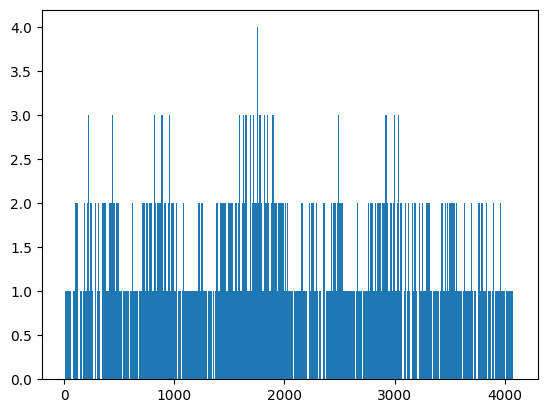

In [79]:
rules1 = [(0,1,1)]
rewards1 = [1]

print(rules1,rewards1)

sequence_cost = []
for sequence in sequence_list:
    rew = 0
    rew += estimate_cost(sequence,rules1, rewards1)
    sequence_cost.append(rew)
sequence_cost = np.array(sequence_cost)
# sequence_cost = sequence_cost /np.linalg.norm(sequence_cost)

plt.bar([i for i in np.arange(len(sequence_list))],sequence_cost,width=1.5)
plt.show()

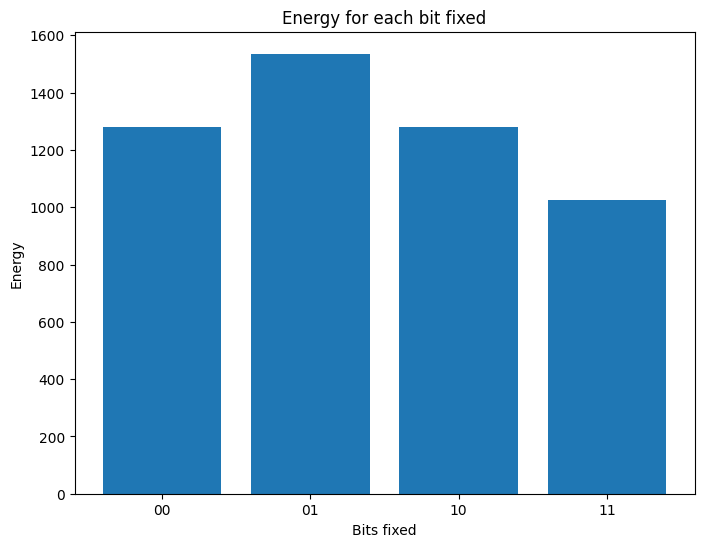

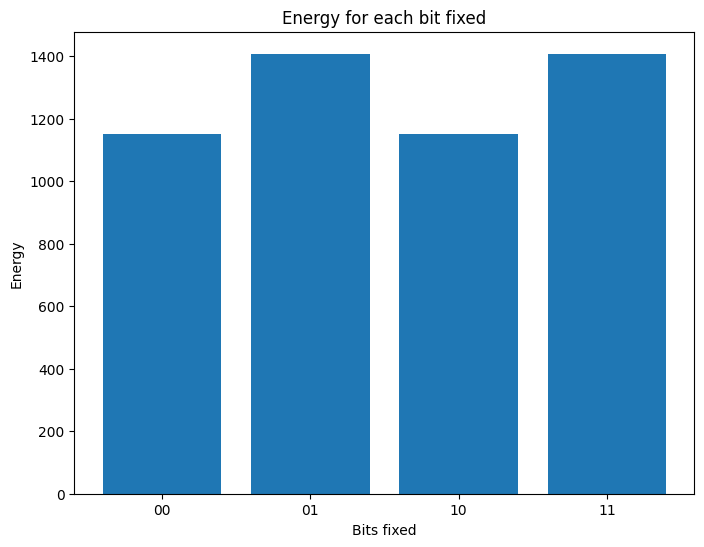

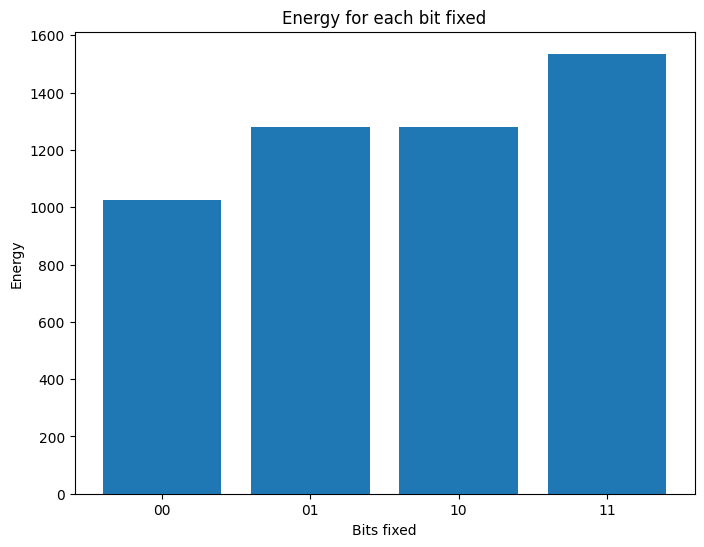

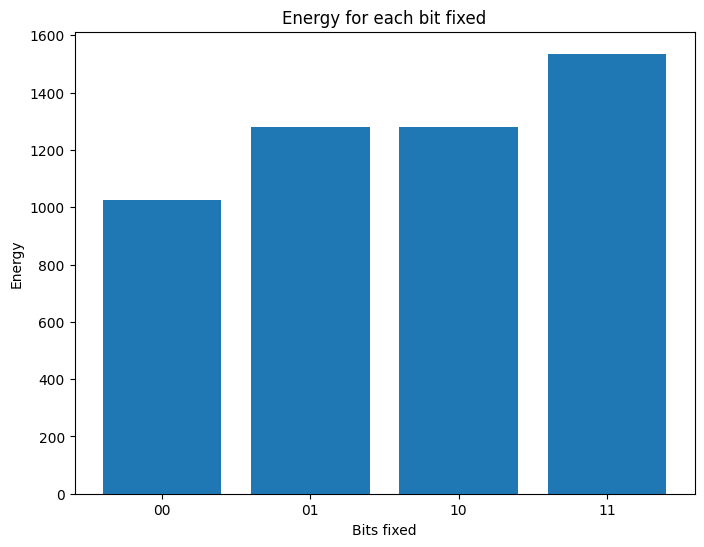

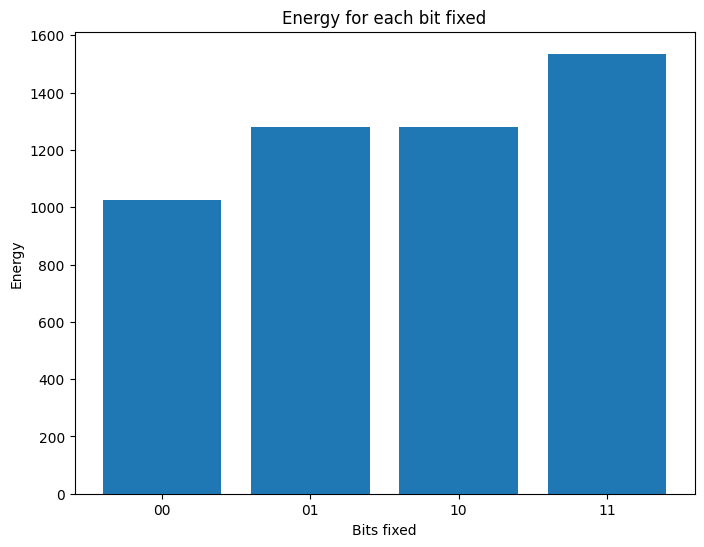

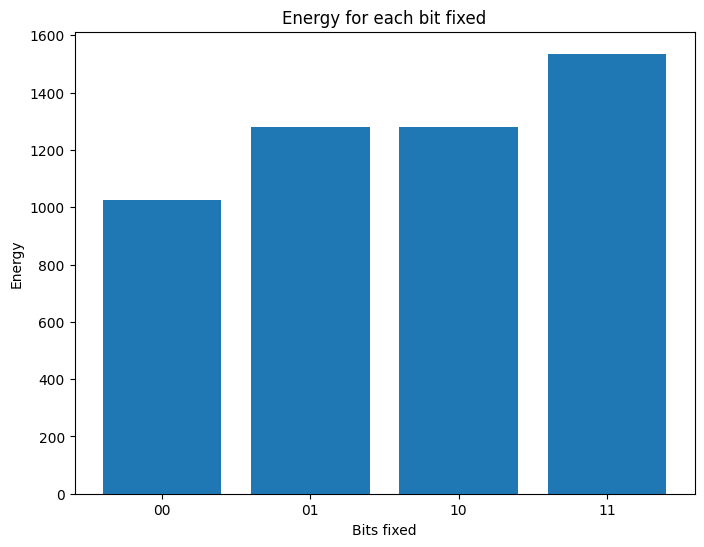

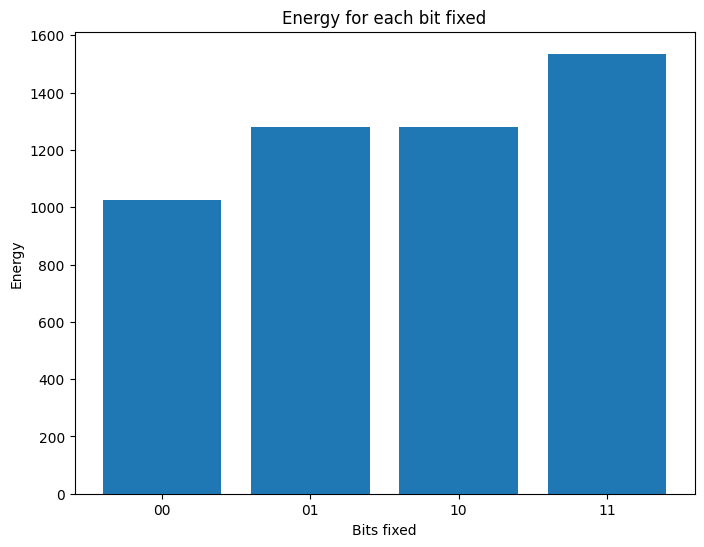

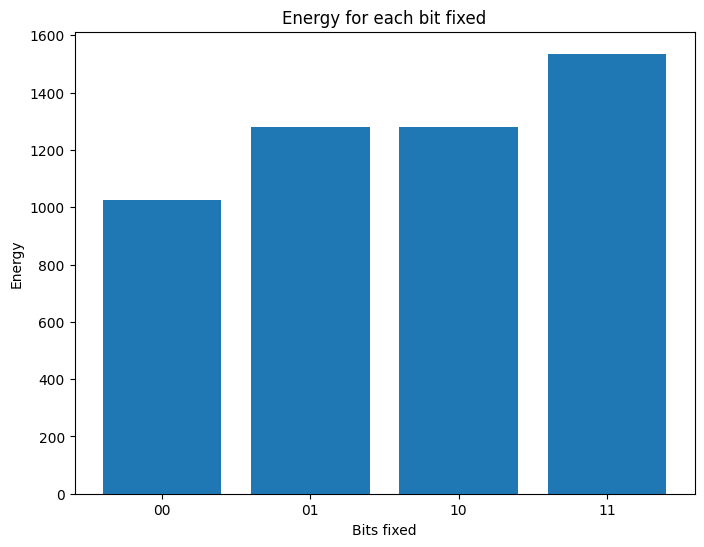

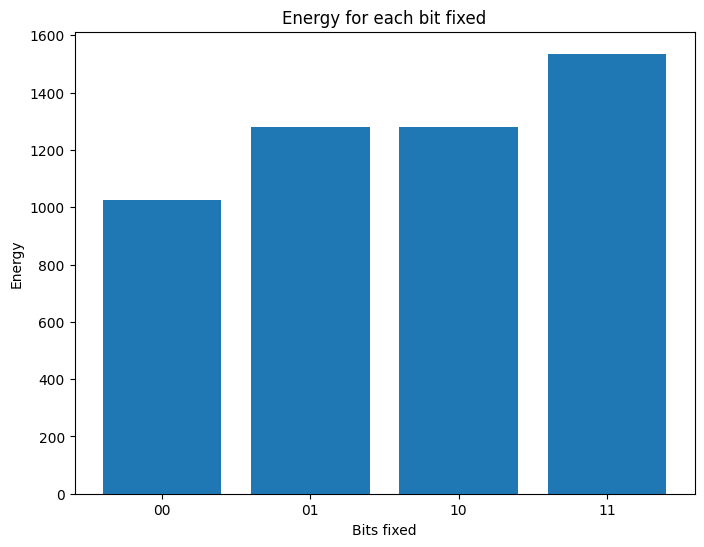

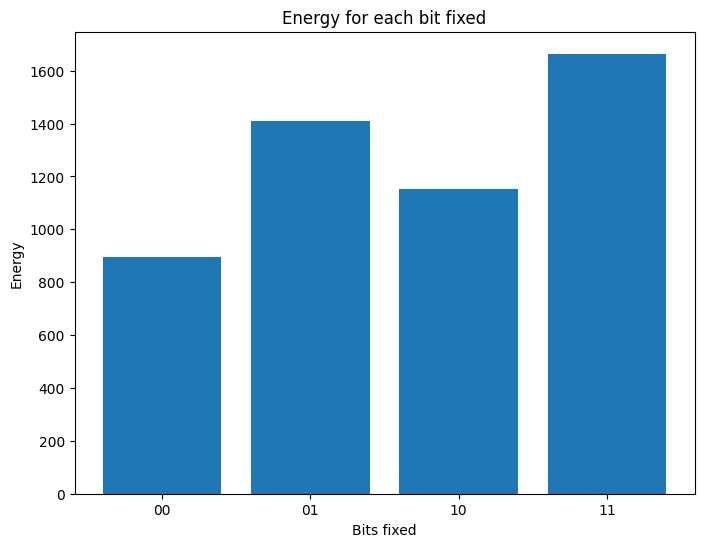

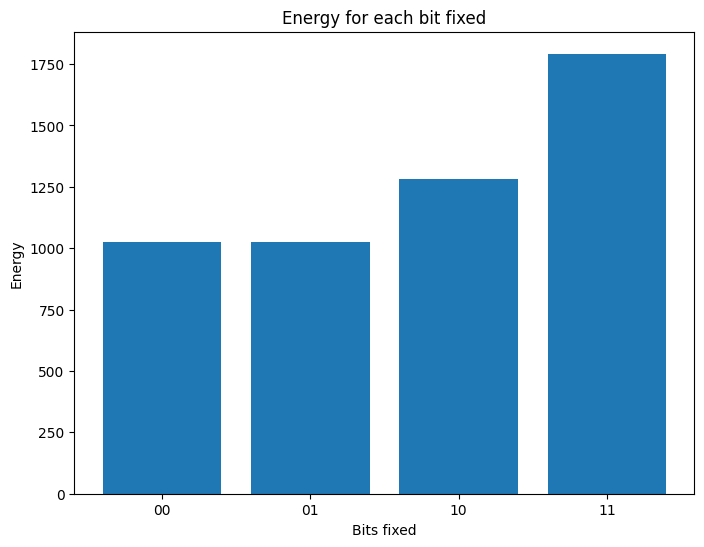

In [76]:
#pairs
all_pat = []
for i in range(n-1):
    all_pat += create_specific_patterns(i,i+1,n)
Phi = np.array([dev_pattern(p) for p in all_pat])

y = Phi @ sequence_cost

cpt = 0
binary_strings = []
values = []

for pat,val in zip(all_pat,y):
    # print(format(cpt, '02b') + ":" )
    # print(pat)
    # print(val)
    
    # Collect data for plotting
    binary_strings.append(format(cpt, '02b'))
    values.append(val)
    
    cpt= (cpt+1) %4
    
    # When cpt goes back to 0, plot the bar diagram
    if cpt == 0 and len(binary_strings) > 0:
        plt.figure(figsize=(8, 6))
        plt.bar(binary_strings, values)
        plt.xlabel('Bits fixed')
        plt.ylabel('Energy')
        plt.title('Energy for each bit fixed')
        plt.show()
        
        # Reset for next group
        binary_strings = []
        values = []

In [77]:
format(np.argmax(Phi.T @ y),'010b')

'11111111111'

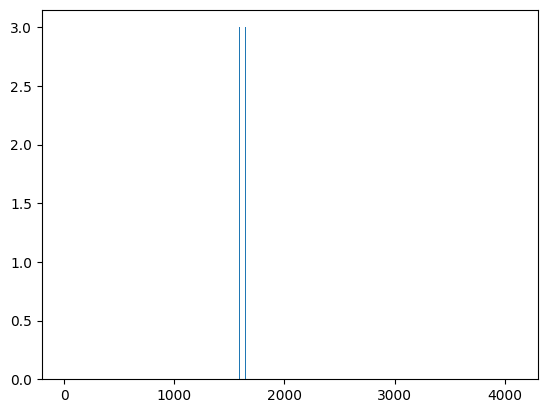

In [87]:
# Uniformly sample indices from sequence_cost
num_samples = 1000  # Change this to the desired number of samples
sample_indices = np.random.choice(len(sequence_cost), size=num_samples, replace=False)
sampled_values = sequence_cost[sample_indices]

# Plot sampled_values on the same x-axis as sequence_cost
sampled_bar = np.zeros_like(sequence_cost)
sampled_bar[sample_indices] = sampled_values
sampled_bar[sampled_bar<=2]=0

plt.bar(np.arange(len(sequence_cost)), sampled_bar, color='C0')
plt.show()

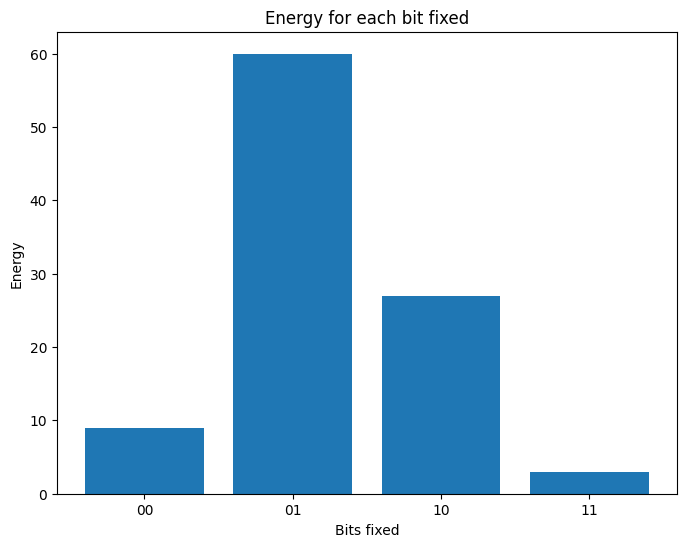

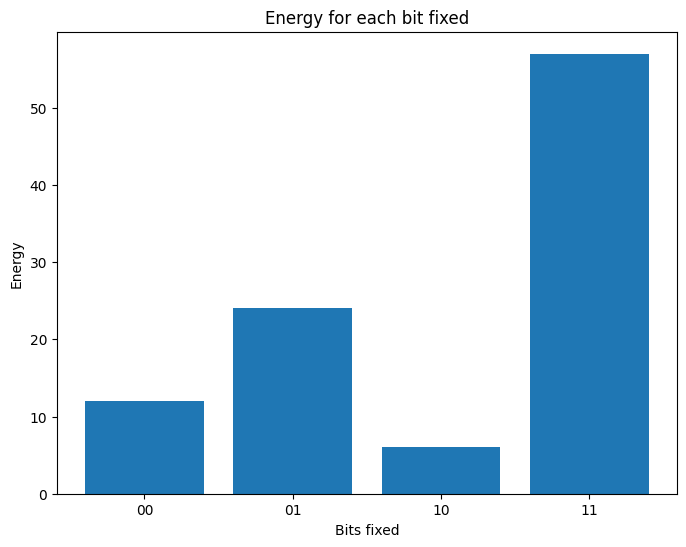

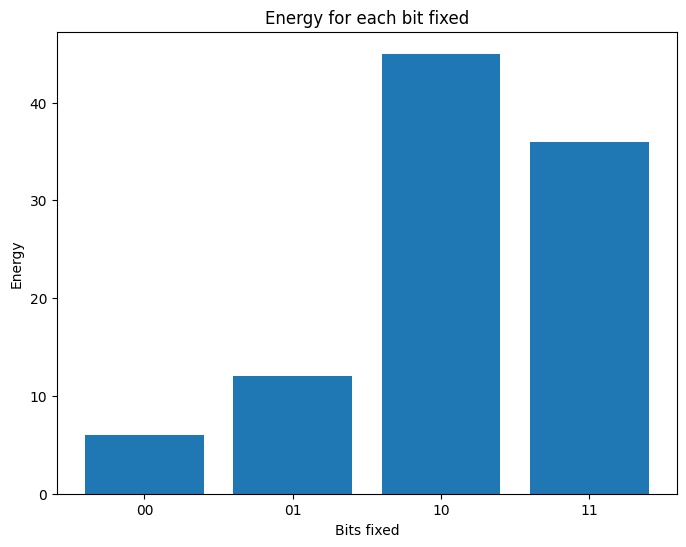

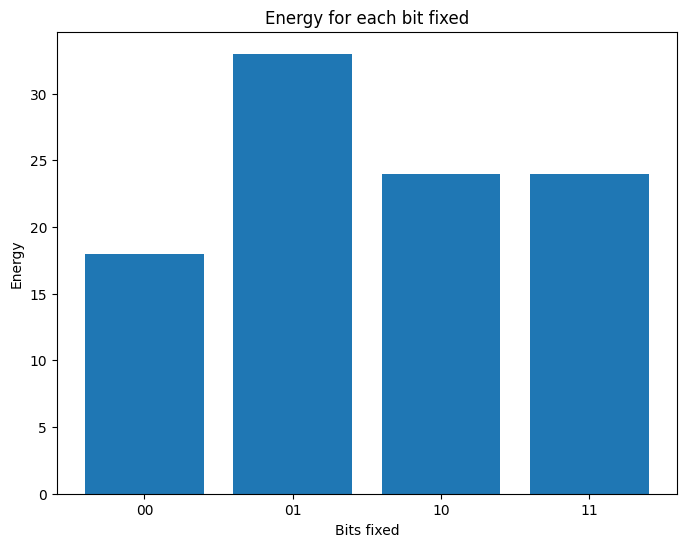

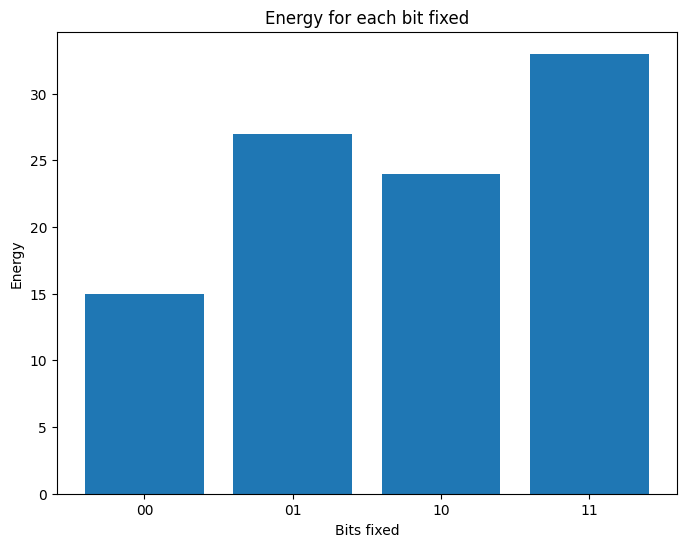

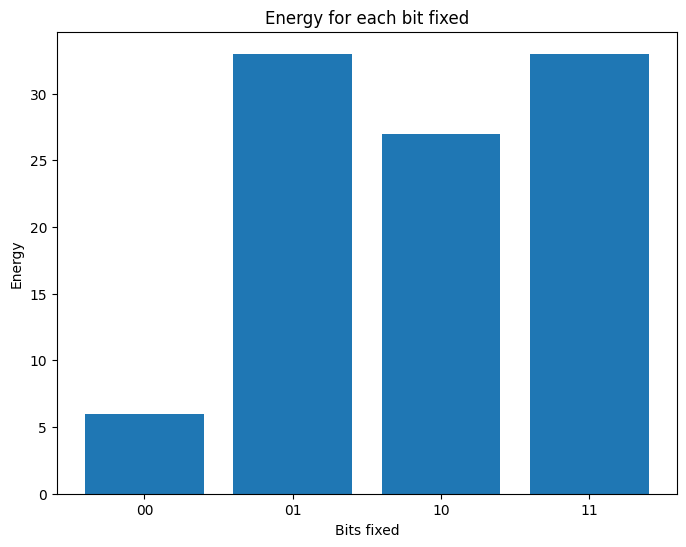

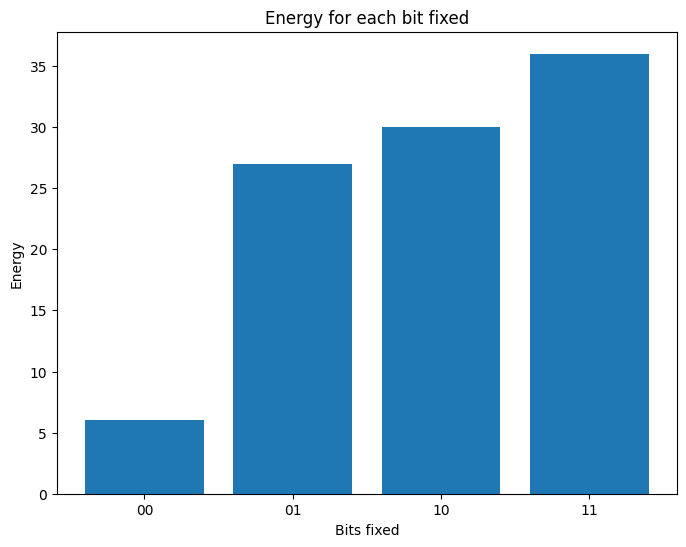

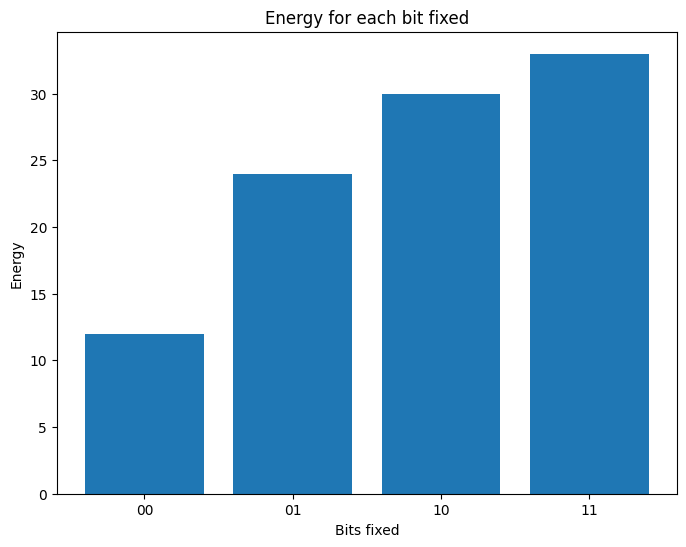

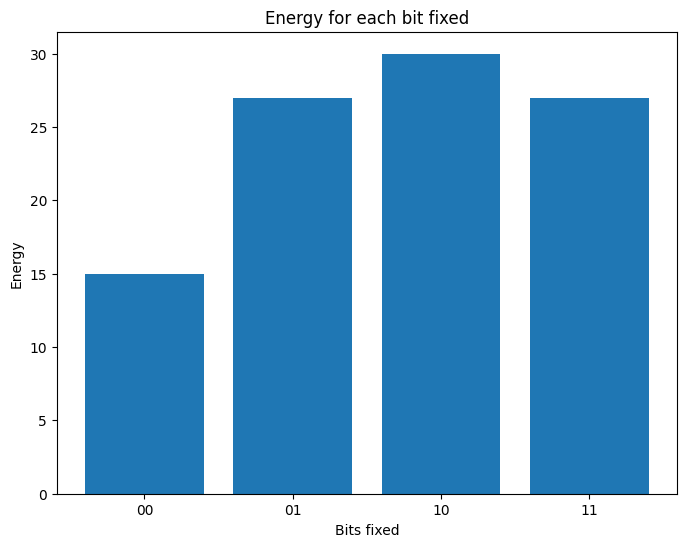

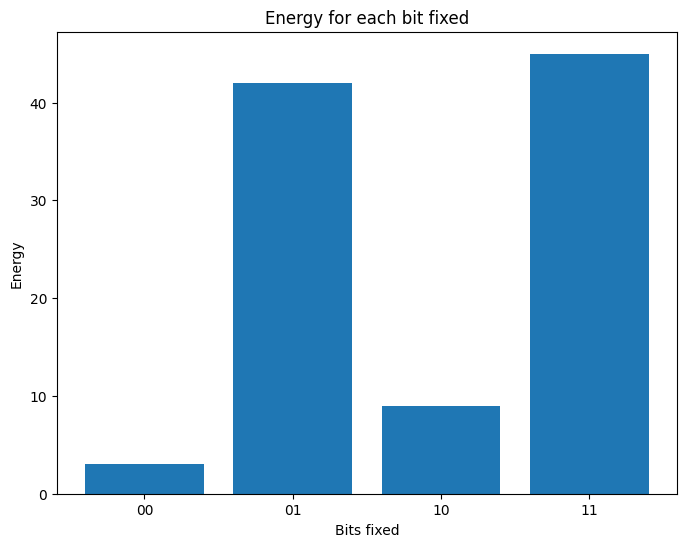

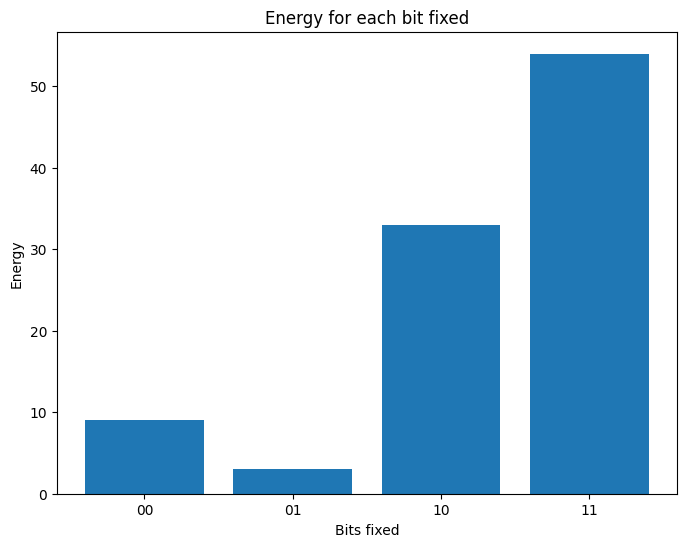

In [88]:
#pairs
all_pat = []
for i in range(n-1):
    all_pat += create_specific_patterns(i,i+1,n)
Phi = np.array([dev_pattern(p) for p in all_pat])

y = Phi @ sampled_bar

cpt = 0
binary_strings = []
values = []

for pat,val in zip(all_pat,y):
    # print(format(cpt, '02b') + ":" )
    # print(pat)
    # print(val)
    
    # Collect data for plotting
    binary_strings.append(format(cpt, '02b'))
    values.append(val)
    
    cpt= (cpt+1) %4
    
    # When cpt goes back to 0, plot the bar diagram
    if cpt == 0 and len(binary_strings) > 0:
        plt.figure(figsize=(8, 6))
        plt.bar(binary_strings, values)
        plt.xlabel('Bits fixed')
        plt.ylabel('Energy')
        plt.title('Energy for each bit fixed')
        plt.show()
        
        # Reset for next group
        binary_strings = []
        values = []

In [86]:
format(np.argmax(Phi.T @ y),'010b')

'11011110111'